In [54]:
%load_ext autoreload
%autoreload 2

from environment import SimpleSlotEnvironment
from trainer import SimpleSlotTrainer
from model import SimpleRNN
from scheduler import ReversalScheduler
from itertools import permutations
from config_slot import ConfSlot
import numpy as np
import torch

config = ConfSlot()
print(config.port_dim, config.trial_len)
layouts = [p for p in permutations(range(config.port_dim), config.trial_len)]
layouts = np.array(layouts)
n_layouts = layouts.shape[0]
# q: random selection of elements from a list (layouts) without replacement
train_idxs = np.random.choice(np.arange(n_layouts), size=int(0.8*n_layouts), replace=False)
train_layouts = layouts[train_idxs]

train_env = SimpleSlotEnvironment(config, train_layouts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
50 2


In [55]:
inputs, targets, groundtruths = train_env.get_batch(num_trials=config.num_trials)
print(inputs.shape)

torch.Size([128, 8, 51])


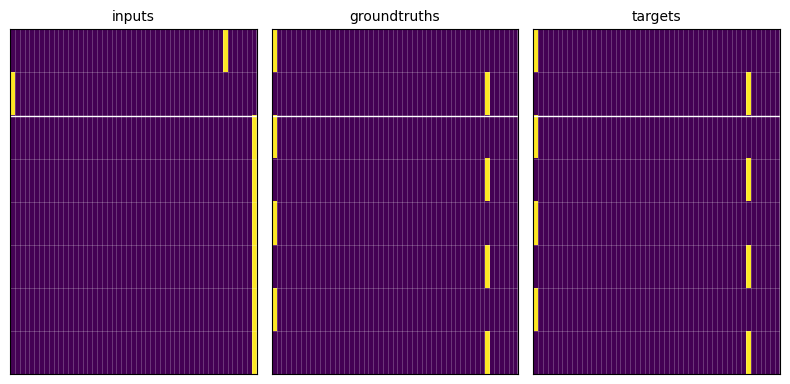

In [56]:
b = 0

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(8, config.num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto')
    ax.axvline(x=config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=config.r_dim + config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,2):
        ax.axhline(y=i * config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')

plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle

In [57]:
model = SimpleRNN(config)

Using standard RNN


In [58]:
# model.load_state_dict(torch.load(os.path.join(load_dir, 'weights_4000.pth')))
config.lr = config.lr
config.batch_size = 128
optimizer_func = torch.optim.AdamW
optimizer_kwargs = {"lr": config.lr, "weight_decay": config.weight_regularization, "amsgrad": config.amsgrad}
scheduler_func = torch.optim.lr_scheduler.LinearLR
scheduler_kwargs = {"start_factor": 1.0, "end_factor": 0.1, "total_iters": config.decay_epochs}
env_scheduler = ReversalScheduler(total_iters=config.dropout_decay_epochs)

trainer = SimpleSlotTrainer(model, 
                          config, 
                          optimizer_func, 
                          scheduler_func,
                          env_scheduler=env_scheduler, 
                          optimizer_kwargs=optimizer_kwargs, 
                          scheduler_kwargs=scheduler_kwargs)

trainer.train()

2024-02-05/b138133/14:13
Making directory:  ../summaries/2024-02-05/b138133/14:13
Epoch 1
{'dropout': 0.0}
TRAIN
x tensor([5.4688, 0.7812])
INFO:trainer:Train loss {'weight': 2.1685082174371928e-05, 'activity': 0.03153589367866516, 'x': 3.924344778060913, 'r': nan, 'a': nan}
TEST
x tensor([3.9062, 1.0417])
INFO:trainer:Test loss {'weight': 2.1685082174371928e-05, 'activity': 0.031546130776405334, 'x': 3.9198577404022217, 'r': nan, 'a': nan}
INFO:trainer:Completed epoch 0 with train loss nan in 0.4609s
Epoch 2
{'dropout': 0.0}
TRAIN
x tensor([27.3438,  1.8229])
INFO:trainer:Train loss {'weight': 2.205094824603293e-05, 'activity': 0.02927287481725216, 'x': 3.8912343978881836, 'r': nan, 'a': nan}
TEST
x tensor([21.6146,  3.1250])
INFO:trainer:Test loss {'weight': 2.205094824603293e-05, 'activity': 0.029328452423214912, 'x': 3.892498731613159, 'r': nan, 'a': nan}
INFO:trainer:Completed epoch 1 with train loss nan in 0.4136s
Epoch 3
{'dropout': 0.0}
TRAIN
x tensor([43.7500, 15.6250])
INFO:t

KeyboardInterrupt: 

In [62]:
hidden = None
config.batch_size = 10000
with torch.no_grad():
    inputs, targets, groundtruths = trainer.test_env.get_batch(config.num_trials)
    # Convert data to tensors
    data_tensor = inputs.to(dtype=config.dtype, device=config.dev)
    target_tensor = targets.to(dtype=config.dtype, device=config.dev)

"""Loop through trials (chunks of 4 timesteps)."""
# Forward pass
logits, hidden, hiddens = model(data_tensor, hidden)

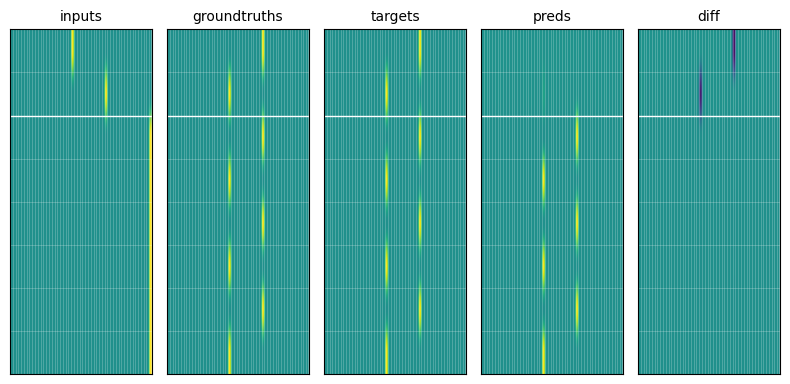

In [63]:
b = 1

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(8, config.num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto', vmin=-1, vmax=1)
    ax.axvline(x=config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=config.r_dim + config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,2):
        ax.axhline(y=i * config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')
preds = torch.nn.functional.softmax(logits.detach()[b, :, :], dim=-1)
display_mat(axes[3], preds, title='preds')
display_mat(axes[4], preds - targets[b, :, :], title='diff')


plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle

In [64]:
hiddens_detached = hiddens.detach()

h_means = []
for i in range(config.port_dim):
    layouts = trainer.test_env.layouts[trainer.test_env.idxs]
    batches, offsets = np.where(layouts == i)
    
    h_collected = []
    for batch, offset in zip(batches, offsets):
        h_shift = hiddens_detached[batch, offset:offset+(config.num_trials-1)*config.trial_len, :]
        h_collected.append(h_shift)

    h_collected = torch.stack(h_collected)
    print(h_collected.shape)
    h_mean = torch.mean(h_collected, dim=0).numpy()

    h_means.append(h_mean)
    # layouts = np.argmax(inputs[:, :config.trial_len, :], axis=-1)

h_means = np.stack(h_means, axis=0)
print(h_means.shape)

torch.Size([455, 6, 256])
torch.Size([438, 6, 256])
torch.Size([464, 6, 256])
torch.Size([344, 6, 256])
torch.Size([294, 6, 256])
torch.Size([503, 6, 256])
torch.Size([438, 6, 256])
torch.Size([274, 6, 256])
torch.Size([340, 6, 256])
torch.Size([387, 6, 256])
torch.Size([433, 6, 256])
torch.Size([504, 6, 256])
torch.Size([423, 6, 256])
torch.Size([548, 6, 256])
torch.Size([468, 6, 256])
torch.Size([332, 6, 256])
torch.Size([369, 6, 256])
torch.Size([471, 6, 256])
torch.Size([343, 6, 256])
torch.Size([463, 6, 256])
torch.Size([477, 6, 256])
torch.Size([443, 6, 256])
torch.Size([377, 6, 256])
torch.Size([343, 6, 256])
torch.Size([369, 6, 256])
torch.Size([251, 6, 256])
torch.Size([388, 6, 256])
torch.Size([574, 6, 256])
torch.Size([386, 6, 256])
torch.Size([382, 6, 256])
torch.Size([383, 6, 256])
torch.Size([316, 6, 256])
torch.Size([335, 6, 256])
torch.Size([490, 6, 256])
torch.Size([506, 6, 256])
torch.Size([300, 6, 256])
torch.Size([318, 6, 256])
torch.Size([436, 6, 256])
torch.Size([

In [65]:
h_means_reshape = np.reshape(h_means, (config.port_dim, config.num_trials-1, config.trial_len, config.hidden_dim))
h_means_all = np.mean(h_means_reshape, axis=1)

neurons = []
for i in range(config.hidden_dim):
    _, idx = np.where(h_means_all[:, :, i] == np.max(h_means_all[:, :, i]))
    if idx != (config.target_shift % config.trial_len):
        neurons.append(i)

print(neurons)

[46, 51, 59, 62, 68, 69, 77, 89, 97, 99, 108, 117, 165, 167, 179, 189, 204, 205, 209, 217, 221, 228, 240, 246, 253]


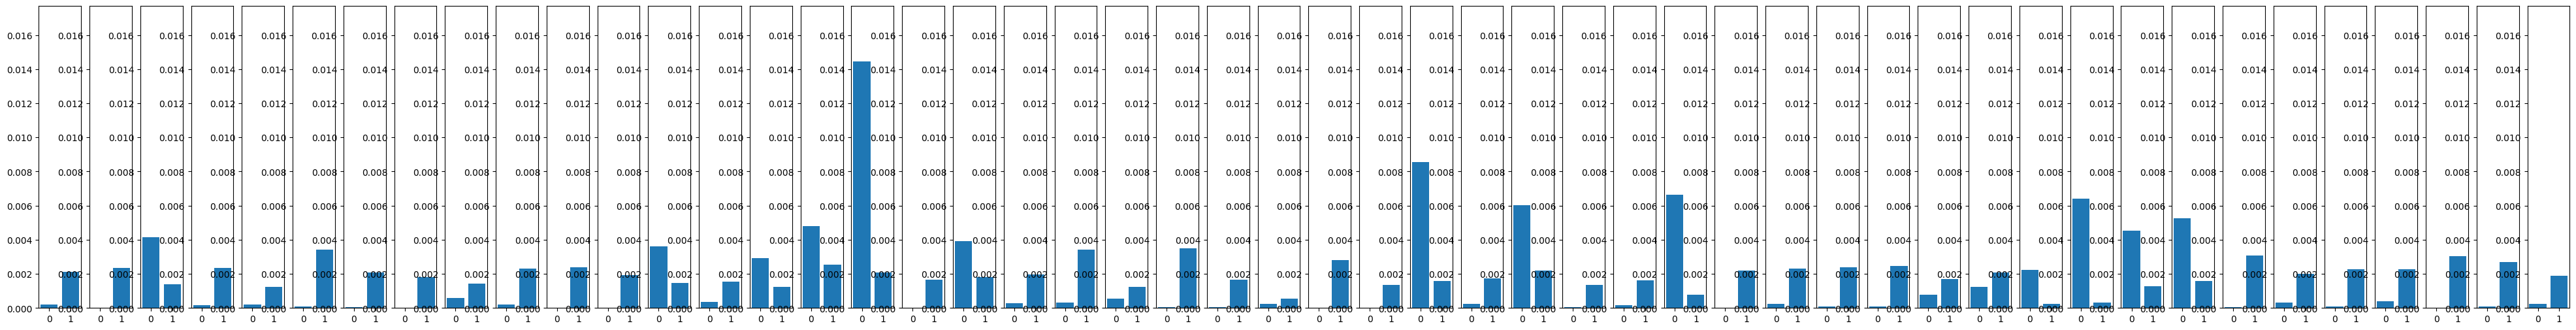

In [70]:
k=62
fig, axes = plt.subplots(1, config.port_dim, figsize=(config.port_dim, 6))
vmax = np.max(h_means[:, :, k])
for i in range(config.port_dim):
    h_ = np.reshape(h_means[i, :, k], (config.num_trials-1, config.trial_len))
    h_ = np.mean(h_, axis=0)
    axes[i].bar(np.arange(config.trial_len), h_, label=str(i))
    axes[i].set_ylim([0, vmax])

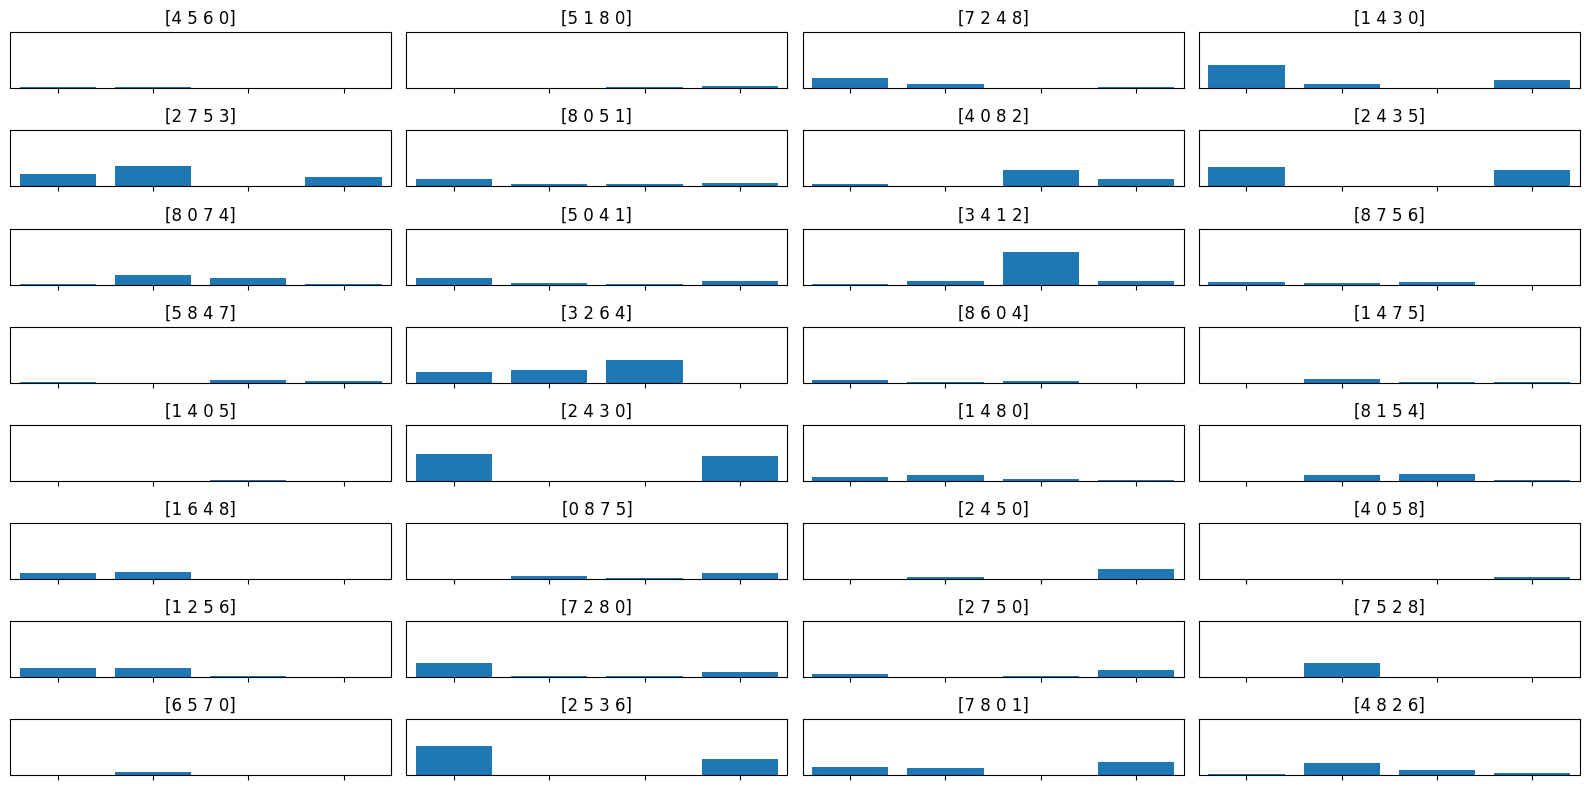

In [400]:
fig, axes = plt.subplots(8, 4, figsize=(16,8), sharex=True, sharey=True)
h = hiddens.detach().numpy()
k = 0
vmax = np.max(h[:,:,k])
for i, ax in enumerate(axes.flatten()):
    h_ = h[i, config.trial_len:, k]
    h_ = h_.reshape(config.num_trials-1, config.trial_len)
    h_mean = np.mean(h_, axis=0)
    ax.bar(np.arange(config.trial_len), h_mean)
    ax.xaxis.set_ticks(np.arange(0, config.trial_len))
    ax.xaxis.set_ticklabels([])
    ax.set_xlim([-0.5, config.trial_len-0.5])
    ax.set_ylim([0, vmax])
    ax.yaxis.set_visible(False)
    layout = trainer.test_env.layouts[trainer.test_env.idxs[i]]
    ax.set_title(layout)

plt.tight_layout()

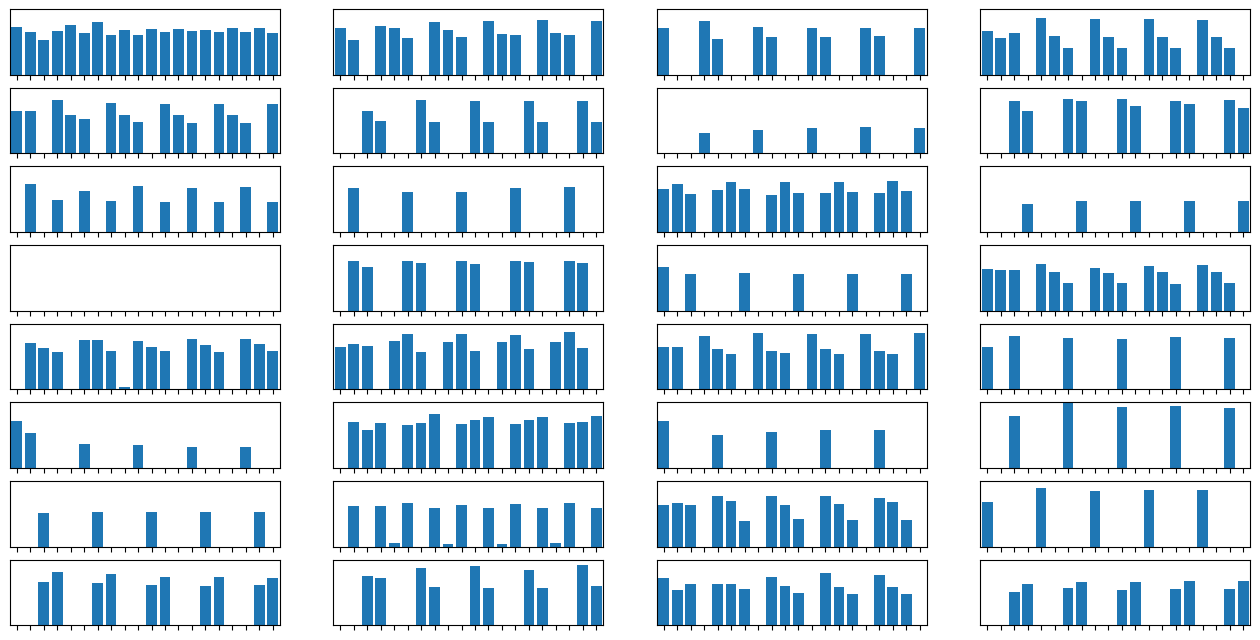

In [386]:
fig, axes = plt.subplots(8, 4, figsize=(16,8), sharex=True, sharey=True)
h = hiddens.detach().numpy()
k = 121
vmax = np.max(h[:,:,k])
for i, ax in enumerate(axes.flatten()):
    ax.bar(np.arange(config.trial_len * config.num_trials), h[i,:,k])
    ax.xaxis.set_ticks(np.arange(0, config.trial_len * config.num_trials))
    ax.xaxis.set_ticklabels([])
    ax.set_xlim([-0.5, config.trial_len * config.num_trials-0.5])
    ax.set_ylim([0, vmax])
    ax.yaxis.set_visible(False)

In [140]:
%load_ext autoreload
%autoreload 2

from environment import ReversalEnvironment
from trainer import ReversalTrainer, train_test_split
from model import SimpleRNN
from scheduler import ReversalScheduler
from itertools import permutations
from config_test import Conf
import numpy as np
import torch

config = Conf()
train_layouts, test_layouts, all_layouts = train_test_split(config.port_dim, init_port=config.init_step is not None)
print(train_layouts.shape, test_layouts.shape, all_layouts.shape)
train_env = ReversalEnvironment(config, train_layouts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1952, 2) (498, 2) (2450, 2)


In [141]:
inputs, targets, groundtruths = train_env.get_batch(config.num_trials, {'dropout': 0.0})
print(inputs.shape)

torch.Size([128, 8, 104])


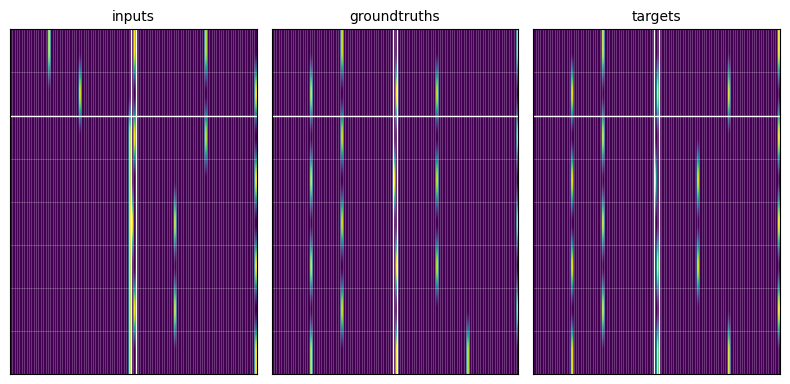

In [142]:
b = 0

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(8, config.num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto')
    ax.axvline(x=config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=config.r_dim + config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,2):
        ax.axhline(y=i * config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')

plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle

In [143]:
model = SimpleRNN(config)

Using standard RNN


In [145]:
# model.load_state_dict(torch.load(os.path.join(load_dir, 'weights_4000.pth')))
config.lr = config.lr
optimizer_func = torch.optim.AdamW
optimizer_kwargs = {"lr": config.lr, "weight_decay": config.weight_regularization, "amsgrad": config.amsgrad}
scheduler_func = torch.optim.lr_scheduler.LinearLR
scheduler_kwargs = {"start_factor": 1.0, "end_factor": 0.1, "total_iters": config.decay_epochs}
env_scheduler = ReversalScheduler(total_iters=config.dropout_decay_epochs)

trainer = ReversalTrainer(model, 
                          config, 
                          optimizer_func, 
                          scheduler_func,
                          env_scheduler=env_scheduler, 
                          optimizer_kwargs=optimizer_kwargs, 
                          scheduler_kwargs=scheduler_kwargs)

print(trainer.test_env.layouts)

trainer.train()

2024-02-05/b138133/p_0.7_lr_1e-04-1e-05_batchsize_128_h_256_wreg_1e-06_hreg_3e-04_thresh_None_wgain_5e-01_lrdecay_10000_dropoutdecay_1000/18:29
[[39 48]
 [48 39]
 [10 36]
 [36 10]
 [14 41]
 [41 14]
 [15 33]
 [33 15]
 [ 2 17]
 [17  2]
 [19 29]
 [29 19]
 [35 38]
 [38 35]
 [ 7 26]
 [26  7]
 [ 1 25]
 [25  1]
 [21 44]
 [44 21]
 [40 49]
 [49 40]
 [11 28]
 [28 11]
 [ 4 31]
 [31  4]
 [ 3 13]
 [13  3]
 [18 34]
 [34 18]
 [12 22]
 [22 12]
 [ 9 42]
 [42  9]
 [ 6 16]
 [16  6]
 [30 32]
 [32 30]
 [ 8 23]
 [23  8]
 [37 43]
 [43 37]
 [24 46]
 [46 24]
 [ 0 45]
 [45  0]
 [ 5 20]
 [20  5]
 [27 47]
 [47 27]
 [ 7 34]
 [34  7]
 [ 4 35]
 [35  4]
 [13 31]
 [31 13]
 [11 29]
 [29 11]
 [38 40]
 [40 38]
 [25 26]
 [26 25]
 [33 46]
 [46 33]
 [28 41]
 [41 28]
 [ 1 18]
 [18  1]
 [ 8 47]
 [47  8]
 [ 2 27]
 [27  2]
 [ 0 12]
 [12  0]
 [ 5  6]
 [ 6  5]
 [10 45]
 [45 10]
 [ 9 39]
 [39  9]
 [22 30]
 [30 22]
 [17 19]
 [19 17]
 [21 49]
 [49 21]
 [23 37]
 [37 23]
 [14 43]
 [43 14]
 [ 3 15]
 [15  3]
 [20 36]
 [36 20]
 [24 44]
 

KeyboardInterrupt: 

In [124]:
hidden = None
config.batch_size = 128

with torch.no_grad():
    inputs, targets, groundtruths = trainer.test_env.get_batch(config.num_trials, env_scheduler.get_params())
    # Convert data to tensors
    data_tensor = inputs.to(dtype=config.dtype, device=config.dev)
    target_tensor = targets.to(dtype=config.dtype, device=config.dev)

"""Loop through trials (chunks of 4 timesteps)."""
# Forward pass
logits, hidden, hiddens = model(data_tensor, hidden)

accuracies, steps = trainer.get_all_accuracies(logits, target_tensor)

x tensor([100., 100.])
r tensor([ 0.7812, 62.2396])
a tensor([3.6458, 0.5208])


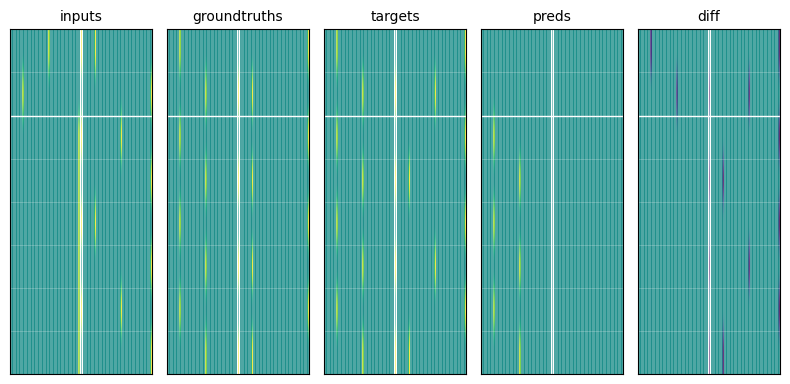

In [125]:
b = 1

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(8, config.num_trials))

def display_mat(ax, data, title=''):
    ax.imshow(data.numpy(), aspect='auto', vmin=-1, vmax=1)
    ax.axvline(x=config.x_dim-0.5, c='w', linewidth=1)
    ax.axvline(x=config.r_dim + config.x_dim-0.5, c='w', linewidth=1)
    for i in range(1,2):
        ax.axhline(y=i * config.trial_len-0.5, c='w', linewidth=1)
    ax.set_title(title, fontsize=10)
    # ax.yaxis.set_visible(False)
    # ax.xaxis.set_visible(False)
    # q: how do I turn on the grid on the plot?
    # a: ax.grid(True)
    # q: its not showing up
    # a: try plt.grid(True)
    # q: its still not showing up
    # Set grid
    ax.set_xticks([i+0.5 for i in range(data.shape[1])])  # Adjust x-ticks to align with grid
    ax.set_yticks([i+0.5 for i in range(data.shape[0])])  # Adjust y-ticks to align with grid
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax.grid(True, which='both', color='white', alpha=0.3, linestyle='-', linewidth=0.5)

def display_curve(ax, data, title='p(A)'):
    trials = data.shape[0]
    ax.plot(data, 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
    ax.set_ylim([0, trials])
    ax.set_xlim([-.01, 1.01])
    ax.invert_yaxis()
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

display_mat(axes[0], inputs[b, :, :], title='inputs')
display_mat(axes[1], groundtruths[b, :, :], title='groundtruths')
display_mat(axes[2], targets[b, :, :], title='targets')
preds = torch.nn.functional.softmax(logits.detach()[b, :, :], dim=-1)
try: display_mat(axes[3], preds, title='preds')
except: pass

try: display_mat(axes[4], preds - targets[b, :, :], title='diff')
except: pass


plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle

In [138]:
a, b, c = train_test_split(config.port_dim)
print(a.shape, b.shape, c.shape)

a, b, c = train_test_split(config.port_dim, init_port=False)
print(a.shape, b.shape, c.shape)



(93600, 3) (24000, 3) (117600, 3)
(1950, 2) (500, 2) (2450, 2)
